In [35]:
from __future__ import print_function

import argparse
import pickle
from time import strftime
import sys
import six
import random

import tensorflow as tf
import numpy as np
import pandas as pd
import lifetable

import matplotlib.pyplot as plt
%matplotlib inline

# TensorFlow numeric type to use for floating point variables
# tf.float32 is 2x faster but doesn't provide necessary accuracy
# tf.float64 will run out of accuracy for high gamma (> 8)
float_type = tf.float64



In [36]:
############################################################
# returns 1928-2015
############################################################

first_year = 1928
last_year = 2015
years = range(first_year, last_year+1) # pythonically yields [1928, 1929...2015]
years_history = len(years)
years_retired = 30
num_cohorts = years_history - years_retired + 1
num_assets = 2

bestfile = "jupyter"
#gamma = 1.0

sp500 = pd.Series([0.4381,-0.083,-0.2512,-0.4384,-0.0864,0.4998,-0.0119,0.4674,0.3194,-0.3534,0.2928,-0.011,
-0.1067,-0.1277,0.1917,0.2506,0.1903,0.3582,-0.0843,0.052,0.057,0.183,0.3081,0.2368,0.1815,
-0.0121,0.5256,0.326,0.0744,-0.1046,0.4372,0.1206,0.0034,0.2664,-0.0881,0.2261,0.1642,0.124,
-0.0997,0.238,0.1081,-0.0824,0.0356,0.1422,0.1876,-0.1431,-0.259,0.37,0.2383,-0.0698,0.0651,
0.1852,0.3174,-0.047,0.2042,0.2234,0.0615,0.3124,0.1849,0.0581,0.1654,0.3148,-0.0306,0.3023,
0.0749,0.0997,0.0133,0.372,0.2268,0.331,0.2834,0.2089,-0.0903,-0.1185,-0.2197,0.2836,0.1074,
0.0483,0.1561,0.0548,-0.3655,0.2594,0.1482,0.021,0.1589,0.3215,0.1352,0.0136], index = years)

bonds=pd.Series([0.0084,0.042,0.0454,-0.0256,0.0879,0.0186,0.0796,0.0447,0.0502,0.0138,0.0421,0.0441,
0.054,-0.0202,0.0229,0.0249,0.0258,0.038,0.0313,0.0092,0.0195,0.0466,0.0043,-0.003,
0.0227,0.0414,0.0329,-0.0134,-0.0226,0.068,-0.021,-0.0265,0.1164,0.0206,0.0569,0.0168,
0.0373,0.0072,0.0291,-0.0158,0.0327,-0.0501,0.1675,0.0979,0.0282,0.0366,0.0199,0.0361,
0.1598,0.0129,-0.0078,0.0067,-0.0299,0.082,0.3281,0.032,0.1373,0.2571,0.2428,-0.0496,
0.0822,0.1769,0.0624,0.15,0.0936,0.1421,-0.0804,0.2348,0.0143,0.0994,0.1492,-0.0825,
0.1666,0.0557,0.1512,0.0038,0.0449,0.0287,0.0196,0.1021,0.201,-0.1112,0.0846,0.1604,
0.0297,-0.091,0.1075,0.0128], index=years)

cpi=pd.Series([-0.0115607,0.005848,-0.0639535,-0.0931677,-0.1027397,0.0076336,0.0151515,0.0298507,
0.0144928,0.0285714,-0.0277778,0,0.0071429,0.0992908,0.0903226,0.0295858,0.0229885,
0.0224719,0.1813187,0.0883721,0.0299145,-0.0207469,0.059322,0.06,0.0075472,0.0074906,
-0.0074349,0.0037453,0.0298507,0.0289855,0.0176056,0.017301,0.0136054,0.0067114,0.0133333,
0.0164474,0.0097087,0.0192308,0.0345912,0.0303951,0.0471976,0.0619718,0.0557029,0.0326633,
0.0340633,0.0870588,0.1233766,0.0693642,0.0486486,0.0670103,0.0901771,0.1329394,0.125163,
0.0892236,0.0382979,0.0379098,0.0394867,0.0379867,0.010979,0.0443439,0.0441941,0.046473,
0.0610626,0.0306428,0.0290065,0.0274841,0.026749,0.0253841,0.0332248,0.017024,0.016119,
0.0268456,0.0338681,0.0155172,0.0237691,0.0187949,0.0325556,0.0341566,0.0254065,0.0408127,
0.0009141,0.0272133,0.0149572,0.0296,0.0174,0.015,0.0076,0.0073], index=years)

real_stocks = sp500 - cpi
real_bonds = bonds - cpi

startval = 100
years_retired = 30
# 1% constant spending
const_spend_pct = .01
const_spend = startval * const_spend_pct

# var spending a function of years left
var_spend_pcts = pd.Series([ 1.0 / (30- ix) for ix in range(30)])

# 65% stocks
stock_allocations = pd.Series(np.ones(years_retired) * 0.65)
bond_allocations = 1 - stock_allocations

pickle_list = [const_spend, var_spend_pcts, stock_allocations, bond_allocations]
pickle.dump( pickle_list, open( bestfile, "wb" ) )




In [37]:
class SafeWithdrawalModel:
    "initialize graph and parameters shared by all retirement cohorts"
    def __init__(self,
                 returns_list, # series with returns for assets
                 names_list, # names of assets
                 allocations_list, # list of % allocated to each asset class
                 start_val, # starting portfolio value e.g. 100
                 const_spend,
                 var_spend_pcts,
                 gamma,
                 survival,
                 verbose=False):

        # read params, initialize Tensorflow graph and session
        # set up ops specific to model
        self.verbose=verbose
        self.startval=startval
        self.returns_list = returns_list
        self.names_list = names_list
        self.num_assets = len(self.names_list)
        self.start_val = start_val
        self.ret_years = len(allocations_list[0])
        self.const_spend = const_spend
        self.var_spend_pcts = var_spend_pcts
        self.survival=survival
        self.gamma = gamma

        # model will have a cohort_history object, optimizer object
        # initialize with placeholder, needs rest of model initialized first
        self.cohort_history = None
        self.optimizer = None

        self.first_year = returns_list[0].index[0]
        self.last_year = returns_list[0].index[-1]
        self.total_cohorts = len(returns_list[0])
        self.ret_cohorts = self.total_cohorts - self.ret_years + 1

        print('%s Create TensorFlow graph and session' % strftime("%H:%M:%S"))
        self.graph = tf.Graph()
        self.sess = tf.Session(graph = self.graph)
        self.return_ops = []
        self.allocation_ops = []

        with self.graph.as_default():
            with tf.device("/cpu:0"):
                # some constants
                self.zero = tf.constant(0.0, dtype=float_type, name="zero")
                self.one = tf.constant(1.0, dtype=float_type, name="one")
                self.one_hundred = tf.constant(100.0, dtype=float_type, name="one_hundred")
                self.ten_thousand = tf.constant(10000.0, dtype=float_type, name="ten_thousand")
                self.one_hundred_thousand = tf.constant(100000.0, dtype=float_type, name="one_million")
                self.one_million = tf.constant(1000000.0, dtype=float_type, name="one_million")
                self.very_small_amts = tf.constant(np.array([0.000001] * self.ret_years), dtype=float_type, name="very_small_amts")
                self.zero_years = tf.constant(np.zeros(self.ret_years), dtype=float_type, name = "zero_years")
                self.one_years = tf.constant(np.ones(self.ret_years), dtype=float_type, name="one_years")
                self.ret_years_op = tf.constant(self.ret_years, dtype=float_type, name="ret_years")
                #gamma
                self.gamma_op = tf.constant(gamma, dtype=float_type, name="gamma")
                self.one_minus_gamma = tf.sub(self.one, self.gamma, name="one_minus_gamma")
                self.inv_one_minus_gamma = tf.div(self.one, self.one_minus_gamma, name="inv_one_minus_gamma")

                self.cost_multiplier = self.one_million

                # generate op for start_val
                self.start_val_op = tf.constant(100.0, dtype=float_type, name ="port_start_val")

                # generate ops for returns
                for prefix, return_series in zip(names_list, returns_list):
                    self.return_ops.append(self.gen_tf_const_list(return_series, "%s_return" % prefix,
                                                                  verbose=self.verbose))

                # only implemented for n=2 assets
                # generate ops for allocations for first n-1 assets
                prefix = names_list[0]
                alloc_series = allocations_list[0]
                stock_alloc_ops = self.gen_tf_var_list(alloc_series, "%s_alloc" % prefix, verbose=self.verbose)
                self.allocation_ops.append(stock_alloc_ops)

                # ops for soft constraints: 0 < stock allocation < 1
                self.alloc_min_0_ops = self.gen_zero_min_list(stock_alloc_ops, "alloc_min_0", verbose=self.verbose)
                self.cost_alloc_min_0_op = tf.mul(self.cost_multiplier,
                                                  tf.add_n(self.alloc_min_0_ops, name="cost_alloc_min_0"))

                self.alloc_max_1_ops = self.gen_one_max_list(stock_alloc_ops, "alloc_max_1", verbose=self.verbose)
                self.cost_alloc_max_1_op = tf.mul(self.cost_multiplier,
                                                  tf.add_n(self.alloc_max_1_ops, name = "cost_alloc_max_1"))

                # ops for soft constraints: declining stock allocation
                # why do we do this? for exmple, 1966 is the worst cohort, and 1974 is its worst stock return (-40%)
                # to maximize CE, optimization sets stock allocation at a minimum to not run out of money in worst cohort
                # it will go e.g. 80% stock alloc in year 8 and add 56% in year 9, return to 80% in year 10
                # to avoid artifacts like that, knowing stock allocation should decline over time, we add this constraint
                # add a large penalty when stock allocation increases from one year to next
                self.alloc_decrease_ops = self.gen_diff_list(stock_alloc_ops, "alloc_decrease", verbose=self.verbose)
                self.cost_alloc_decrease_op = tf.mul(self.cost_multiplier,
                                                     tf.add_n(self.alloc_decrease_ops, name="alloc_decrease_cost_op"))
                # last asset is 1-previous assets
                bond_alloc_ops = []

                var_prefix = "%s_alloc" % names_list[1]
                print ('%s Create ops for %s' % (strftime("%H:%M:%S"), var_prefix))
                for ix, op in enumerate(stock_alloc_ops):
                    var_name = "%s_%d" % (var_prefix, ix)
                    if self.verbose:
                        print("Create %s" % (var_name))
                    var_op = tf.sub(self.one, stock_alloc_ops[ix], name=var_name)
                    bond_alloc_ops.append(var_op)
                self.allocation_ops.append(bond_alloc_ops)

                # generate ops for const, var spending
                self.const_spending_op = tf.Variable(const_spend, dtype=float_type, name="const_spend")
                self.sess.run(self.const_spending_op.initializer)

                self.var_spending_ops = self.gen_tf_var_list(self.var_spend_pcts, "var_spend", verbose=self.verbose)

                # all ops to be trained
                self.all_var_ops = [self.const_spending_op] + self.var_spending_ops + self.allocation_ops[0]

                # op for soft constraint: const spending > 0
                self.cspend_min_0_op = tf.maximum(self.zero, tf.neg(self.const_spending_op,
                                                                    name="neg_cspend_min_0_op"),
                                                  name="cspend_min_0_op")
                self.cost_cspend_min_0_op = tf.mul(self.cost_multiplier, self.cspend_min_0_op, name="cost_cspend_min_0")

                # op for soft constraint: var spending > 0
                self.vspend_min_0_ops = self.gen_zero_min_list(self.var_spending_ops, "vspend_min_0", verbose=self.verbose)
                self.cost_vspend_min_0_op = tf.mul(self.cost_multiplier,
                                                   tf.add_n(self.vspend_min_0_ops, name="cost_vspend_min_0"))

                if survival is not None:
                    survival_array=np.array(survival)
                    self.survival_tensor = tf.constant(survival_array, dtype=float_type, name="survival_tensor")

                # global step counter
                self.step_count = tf.Variable(0, dtype=float_type, name="step_count", trainable=False)
                self.increment_step = self.step_count.assign_add(1)

                #init op
                self.init_op = tf.initialize_all_variables()

    def __del__(self):
        """When deleting model, close session, clear default graph"""
        print("Destructor reset graph")
        try:
            with self.graph.as_default():
                tf.reset_default_graph()
        except Exception, e:
            print ("Destructor couldn't reset graph: %s" % str(e))

        try:
            print ("Destructor close Tensorflow session")
            self.sess.close()
        except Exception, e:
            print ("Destructor couldn't close session: %s" % str(e))


    def gen_tf_const_list(self, const_iter, const_prefix, start_index=0, verbose=False):
        "take a list or iterator of values, generate and return tensorflow constant ops for each"
        print ('%s Create constants %s' % (strftime("%H:%M:%S"), const_prefix))
        with self.graph.as_default():
            with tf.device("/cpu:0"):

                const_list = []
                for ix, const in enumerate(const_iter):
                    const_name = "%s_%d" % (const_prefix, start_index + ix)
                    if verbose:
                        print("Set constant %s to %f" % (const_name, const))
                    const_list.append(tf.constant(const, dtype=float_type, name=const_name))

        return const_list

    def gen_tf_var_list(self, var_iter, var_prefix, start_index=0, verbose=False):
        "take a list or iterator of values, generate and return tensorflow Variable ops for each"
        print ('%s Create variables %s' % (strftime("%H:%M:%S"), var_prefix))
        with self.graph.as_default():
            with tf.device("/cpu:0"):
                var_list = []
                for ix, var in enumerate(var_iter):
                    var_name = "%s_%d" % (var_prefix, start_index + ix)
                    if verbose:
                        print("Create variable %s to %f" % (var_name, var))
                    var_op = tf.Variable(var, dtype=float_type, name=var_name)
                    self.sess.run(var_op.initializer)
                    var_list.append(var_op)

        return var_list

    def get_op_from_list(self, op_list, op_index):
        "take a list of ops, return value of op specified by op_index"
        op = op_list[op_index]
        retval = self.sess.run([op])
        return retval

    def gen_zero_min_list(self, op_iter, op_prefix, start_index=0, verbose=False):
        "take a list or iterator of ops, generate and return an op with is max(-op, 0) for soft constraints > 0"
        print ('%s Create ops for soft constraint %s > 0' % (strftime("%H:%M:%S"), op_prefix))
        with self.graph.as_default():
            with tf.device("/cpu:0"):
                op_list = []
                for ix, op in enumerate(op_iter):
                    op_name = "%s_%d" % (op_prefix, start_index + ix)
                    if verbose:
                        print("Zero_min op %s" % (op_name))
                    new_op = tf.maximum(self.zero, tf.neg(op, name="neg_%s" % op_name), name=op_name)
                    op_list.append(new_op)

        return op_list

    def gen_one_max_list(self, op_iter, op_prefix, start_index=0, verbose=False):
        "take a list or iterator of ops, generate and return an op with is max(op-1, 0) for soft constraints > 0"
        print ('%s Create ops for soft constraint %s < 1' % (strftime("%H:%M:%S"), op_prefix))
        with self.graph.as_default():
            with tf.device("/cpu:0"):
                op_list = []
                for ix, op in enumerate(op_iter):
                    op_name = "%s_%d" % (op_prefix, start_index + ix)
                    if verbose:
                        print("One_max op %s" % (op_name))
                    new_op = tf.maximum(self.zero, tf.sub(op, self.one, name="one_minus_%s" % op_name), name=op_name)
                    op_list.append(new_op)

        return op_list

    def gen_diff_list(self, op_iter, op_prefix, start_index=0, verbose=False):
        "generate and return an op for declining stock alloc constraint over time, max of 0 and decrease"
        print ('%s Create ops for soft constraint, declining stock alloc %s' % (strftime("%H:%M:%S"), op_prefix))
        with self.graph.as_default():
            with tf.device("/cpu:0"):
                op_list = []
                for ix, op in enumerate(op_iter):
                    if ix == 0:
                        continue;
                    op_name = "%s_%d" % (op_prefix, start_index + ix)
                    if verbose:
                        print("diff op %s" % (op_name))

                    new_op = tf.maximum(self.zero, tf.sub(op_iter[ix], op_iter[ix-1]))
                    op_list.append(new_op)

        return op_list

    def gen_ce(self, input_tensor, prefix, survival_tensor=None):
      with tf.device("/cpu:0"):
        with self.graph.as_default():
            input_length = np.float64(input_tensor.get_shape().as_list()[0])

            print("%s Create ce op with gamma: %f" % (strftime("%H:%M:%S"), self.gamma))
            if self.gamma == 1.0:
                # log utility. general CE formula undefined if gamma =1
                # however its limit as gamma -> 1 = log()
                u = tf.reduce_mean(tf.log(input_tensor), name="%s_u" % (prefix))
                #print(self.sess.run(u))
                if survival_tensor is not None:
                    u0 = u
                    u = tf.reduce_mean(tf.mul(u0, survival_tensor, name="%s_u_surv" % (prefix)), name="%s_u" % (prefix))
                ce = tf.exp(u, name="%s_ce" % (prefix))
                print ('%s Create CE op %f' % (strftime("%H:%M:%S"), self.sess.run(ce)))
            else:
                # for high gamma numerical error is significant, and calculation is most accurate near 1
                # so divide by mean, compute ce of series so mean=1
                input_mean = tf.reduce_mean(input_tensor, name="%s_mean" % (prefix))
                input_conditioned = tf.div(input_tensor, input_mean, name="%s_conditioned" % (prefix))

                u1 = tf.pow(input_conditioned, self.one_minus_gamma, name="%s_u1" % (prefix))
                u2 = tf.sub(u1, self.one, name="%s_u2" % (prefix))
                u3 = tf.mul(u2, self.inv_one_minus_gamma, name="%s_u3" % (prefix))
                u = tf.reduce_mean(u3, name="%s_u" % (prefix))

                if survival_tensor is not None:
                    u4 = u
                    u = tf.reduce_mean(tf.mul(u4, survival_tensor, name="%s_u_surv" % (prefix)), name="%s_u" % (prefix))

                ce1 = tf.mul(self.one_minus_gamma, u, name="%s_ce1" % (prefix))
                ce2 = tf.add(ce1, self.one, name="%s_ce2" % (prefix))
                ce3 = tf.pow(ce2, self.inv_one_minus_gamma, name="%s_ce3" % (prefix))
                # multiply by original mean to restore units
                ce = tf.mul(input_mean, ce3, name="%s_ce" % (prefix))

                print ('%s Create CE op %f' % (strftime("%H:%M:%S"), self.sess.run(ce)))
            return ce

       

In [38]:
class Cohort:
    """Cohort represents experience of an individual
       - retiring in a given year
       - using the specified SafeWithdrawal model"""
    def __init__(self, model, cohort_start_year):
        self.model = model
        self.cohort_start_year = cohort_start_year
        self.name = "cohort_%d" % cohort_start_year
        print("%s Instantiating cohort %s" % (strftime("%H:%M:%S"), self.name))
        self.gen_tf_ops()

    def gen_tf_ops(self):

        stock_returns = self.model.return_ops[0]
        bond_returns = self.model.return_ops[1]

        stock_allocs = self.model.allocation_ops[0]
        bond_allocs = self.model.allocation_ops[1]

        self.port_returns_list = []
        self.port_prespend_list = []
        self.port_end_vals_list = []
        self.spend_amts_list = []
        self.spend_amts_nonzero_list = []

        with self.model.graph.as_default():
          with tf.device("/cpu:0"):

            print ("%s Generating %d years from %d" % (strftime("%H:%M:%S"), self.model.ret_years, self.cohort_start_year))

            start_year_ix = self.cohort_start_year - self.model.first_year
            for ix in range(self.model.ret_years):
                op_stock_return = stock_returns[start_year_ix + ix]
                op_stock_alloc = stock_allocs[ix]
                op_bond_return = bond_returns[start_year_ix + ix]
                op_bond_alloc = bond_allocs[ix]

                op_const_spend = self.model.const_spending_op
                op_var_spend = self.model.var_spending_ops[ix]

                op_total_real_return = tf.add(tf.mul(op_stock_alloc, op_stock_return, name="%s_stock_%d" % (self.name, ix)),
                                              tf.mul(op_bond_alloc, op_bond_return, name="%s_bond_%d" % (self.name, ix)),
                                             name="%s_total_return_%d" % (self.name, ix))
                self.port_returns_list.append(op_total_real_return)

                if ix == 0:
                    prev_val = self.model.start_val_op
                else:
                    prev_val = self.port_end_vals_list[ix-1]

                op_port_end_val_prespend = tf.add(prev_val,
                                                  tf.mul(prev_val, self.port_returns_list[ix], name="%s_dolreturn_%d" % (self.name, ix)),
                                                 name="%s_prespend_%d" % (self.name, ix))
                self.port_prespend_list.append(op_port_end_val_prespend)

                desired_spend_amt = tf.add(tf.mul(op_var_spend, op_port_end_val_prespend, name="%s_des_vspend_%d" % (self.name, ix)),
                                           op_const_spend,
                                           name="%s_desired_spend_amt_%d" % (self.name, ix))
                #spend minimum of tmp_spend_amt, port value
                spend_amt = tf.minimum(desired_spend_amt, op_port_end_val_prespend, name="%s_actual_spend_amt_%d" % (self.name, ix))
                self.spend_amts_list.append(spend_amt)

                op_port_end_val = tf.sub(op_port_end_val_prespend, spend_amt, name="%s_endval_%d" % (self.name, ix))
                self.port_end_vals_list.append(op_port_end_val)

            #now that we've computed cohort paths we pack results into 1D Tensors to calc objective
            self.spend_amts = tf.pack(self.spend_amts_list, name="%s_spend_amts" % (self.name))
            self.port_end_vals = tf.pack(self.port_end_vals_list, name="%s_port_end_vals" % (self.name))

            self.mean_spending = tf.reduce_mean(self.spend_amts, name="%s_mean_spending" % (self.name))
            self.sd_spending = tf.sqrt(tf.reduce_mean(tf.pow(tf.sub(self.spend_amts, self.mean_spending), 2)),
                                       name="%s_sd_spending" % (self.name))
            self.min_spending = tf.reduce_min(self.spend_amts, name="%s_min_spending" % (self.name))
            self.max_spending = tf.reduce_max(self.spend_amts, name="%s_max_spending" % (self.name))

            if self.model.gamma == 1.0:
                #spend a tiny amount even if spend is 0 so log is not NaN
                #doesn't really seem like best practice but...
                #0 spend years can't be in final solution
                #and don't want divide by zero errors if optimizer attempts one

                #chain new op off old op but keep a reference to old op around just in case
                self.spend_amts_maybe_zero = self.spend_amts
                self.spend_amts = tf.maximum(self.spend_amts_maybe_zero,
                                             self.model.very_small_amts,
                                             name="%s_actual_spend_nonzero_%d" % (self.name, ix))
                self.total_spending = tf.reduce_sum(self.spend_amts, name="%s_total_spending_nonzero" % (self.name))
            else:
                self.total_spending = tf.reduce_sum(self.spend_amts, name="%s_total_spending" % (self.name))

            if self.model.survival is not None:
                self.ce = self.model.gen_ce_survival(self.spend_amts,
                                                     self.model.survival_tensor,
                                                     "%s_ce" % (self.name))
            else:
                self.ce = self.model.gen_ce(self.spend_amts,
                                            "%s_ce" % (self.name))

        print (self.as_dataframe())

    def get_tf_ops(self):
        return self.model.start_val, self.port_returns_list, self.port_prespend_list, self.spend_amts_list, self.port_end_vals_list, self.total_spending

    def as_dataframe(self):
        port_returns_ops = self.port_returns_list
        port_prespend_ops = self.port_prespend_list
        spend_amts_ops = self.spend_amts_list
        port_end_vals_ops = self.port_end_vals_list
        total_spending = self.total_spending

        port_returns = self.model.sess.run(port_returns_ops)
        port_prespend = self.model.sess.run(port_prespend_ops)
        spend_amts = self.model.sess.run(spend_amts_ops)
        port_end_vals = self.model.sess.run(port_end_vals_ops)

        retlist = []
        for ix in range(self.model.ret_years):
            retlist.append([port_returns[ix],
                            port_prespend[ix],
                            spend_amts[ix],
                            port_end_vals[ix]
                        ])

        years = range(self.cohort_start_year, self.cohort_start_year+self.model.ret_years)
        return pd.DataFrame(retlist, index = years, columns=['portreturn', 'prespend', 'spend_amt', 'end_val'])

                

In [39]:
class CohortHistory:
    """represents a set of cohorts retiring in different years using a strategy,
    to enabling aggregating and summarizing their experiences"""
    def __init__(self, model, cohort_years = None):
        self.model = model
        if cohort_years is None:
            cohort_years = [year for year in range(self.model.first_year,
                                                   self.model.first_year + self.model.ret_cohorts)]

        print('%s Create cohort history, years %d to %d' % (strftime("%H:%M:%S"),
                                                            cohort_years[0], cohort_years[-1]))
        self.cohort_list = [Cohort(model, year) for year in cohort_years]
        self.total_spending_ops = [cohort.total_spending for cohort in self.cohort_list]

    def as_dataframe(self):
        """report on on each cohort by year, e.g. 1928"""
        total_spending_ops = [cohort.total_spending for cohort in self.model.cohort_history.cohort_list]
        mean_spending_ops = [cohort.mean_spending for cohort in self.model.cohort_history.cohort_list]
        sd_spending_ops = [cohort.sd_spending for cohort in self.model.cohort_history.cohort_list]
        min_spending_ops = [cohort.min_spending for cohort in self.model.cohort_history.cohort_list]
        max_spending_ops = [cohort.max_spending for cohort in self.model.cohort_history.cohort_list]
        ce_ops = [cohort.ce for cohort in self.model.cohort_history.cohort_list]

        retlist = []
        years = range(self.model.first_year, self.model.first_year + self.model.ret_cohorts)
        for year, meanspend, sdspend, minspend, maxspend, totalspend, ce in zip(years,
                                                                                self.model.sess.run(mean_spending_ops),
                                                                                self.model.sess.run(sd_spending_ops),
                                                                                self.model.sess.run(min_spending_ops),
                                                                                self.model.sess.run(max_spending_ops),
                                                                                self.model.sess.run(total_spending_ops),
                                                                                self.model.sess.run(ce_ops)):
            retlist.append([meanspend, sdspend, minspend, maxspend, totalspend, ce])

        return pd.DataFrame(retlist, index = years, columns=['mean_spend', 'sd_spend', 'min_spend', 'max_spend', 'total_spend', 'ce'])

    def spend_by_year(self):
        """report spending by year for each cohort (ret_years rows x num_cohorts)"""
        dataframes = [cohort.as_dataframe() for cohort in self.model.cohort_history.cohort_list]
        years = range(self.model.ret_years)
        cohorts = range(len(dataframes))

        retlist = []
        for ix in years:
            spendlist = [df.spend_amt.iloc[ix] for df in dataframes]
            retlist.append(spendlist)

        colnames = ["%d" % (cohort+self.model.first_year) for cohort in cohorts]
        return pd.DataFrame(retlist, index = years, columns=colnames)

    def returns_by_year(self):
        """report returns by year for each cohort (ret_years rows x num_cohorts)"""
        dataframes = [cohort.as_dataframe() for cohort in self.model.cohort_history.cohort_list]
        years = range(self.model.ret_years)
        cohorts = range(len(dataframes))

        retlist = []
        for ix in years:
            returnlist = [df.portreturn.iloc[ix] for df in dataframes]
            retlist.append(returnlist)

        colnames = ["%d" % (cohort+self.model.first_year) for cohort in cohorts]
        return pd.DataFrame(retlist, index = years, columns=colnames)



    def summarize_by_year(self):
        """report on outcomes by retirement year, e.g. retirement year 1, 2...30"""
        dataframes = [cohort.as_dataframe() for cohort in self.model.cohort_history.cohort_list]
        years = range(self.model.ret_years)
        retlist = []
        for ix in years:
            spendlist = np.array([df.spend_amt.iloc[ix] for df in dataframes])
            spend_mean = np.mean(spendlist)
            spend_sd = np.std(spendlist)
            spend_min = np.min(spendlist)
            spend_max = np.max(spendlist)
            retlist.append([spend_mean, spend_sd, spend_min, spend_max])

        return pd.DataFrame(retlist, index = years, columns=['spend_mean', 'spend_sd', 'spend_min', 'spend_max'])




In [40]:
# Optimizer
# Create an op which is the sum of spending in all years
#  - negate it so it will be minimized
#  - add large penalty when a stock allocation is < 0 as a soft constraint
#  - add large penalty when a stock allocation is > 1 as a soft constraint
#  - add large penalty when const or var spencint is < 0 as a soft constraint
#  - result is an op which can be minimized by gradient descent

class CohortHistoryOptimize():
    def __init__(self, model):
        self.model = model
        self.best_objective = 0.0
        self.best_step = 0

        graph = self.model.graph

        with graph.as_default():
          with tf.device("/cpu:0"):

            print ('%s Create optimizer class' % strftime("%H:%M:%S"))
            print ('%s Run variable initializers' % strftime("%H:%M:%S"))
            self.model.sess.run(model.init_op)

            print('%s Create cost ops' % strftime("%H:%M:%S"))
            print('%s Sum %d ce ops' % (strftime("%H:%M:%S"), len(self.model.cohort_history.cohort_list)))
            ce_ops = [cohort.ce for cohort in self.model.cohort_history.cohort_list]
            ce_tensor = tf.pack(ce_ops, name="all_cohorts_ce_tensor")

            # ce over ret_cohorts years
            self.total_ce_op = self.model.gen_ce(ce_tensor, "all_cohorts_ce")

            print("%s Total CE spend, all cohorts: %f" % (strftime("%H:%M:%S"), self.model.sess.run(self.total_ce_op)))
            # basic cost
            cost_op_1 = tf.neg(self.total_ce_op, name="basic_cost")
            print("%s Raw cost objective: %f" % (strftime("%H:%M:%S"), self.model.sess.run(cost_op_1)))

            cost_op_2 = tf.add(cost_op_1, model.cost_alloc_min_0_op, name="cost_add_alloc_min_0")
            print("%s Add soft constraint penalty if stock alloc < 0: %f" % (strftime("%H:%M:%S"),
                                                                            self.model.sess.run(cost_op_2)))

            cost_op_3 = tf.add(cost_op_2, model.cost_alloc_max_1_op, name="cost_add_alloc_max_1")
            print("%s Add soft constraint penalty if stock alloc > 1: %f" % (strftime("%H:%M:%S"),
                                                                            self.model.sess.run(cost_op_3)))

            cost_op_4 = tf.add(cost_op_3, model.cost_vspend_min_0_op, name="cost_vspend_min_0")
            print("%s Add soft constraint penalty if var spending < 0: %f" % (strftime("%H:%M:%S"),
                                                                             self.model.sess.run(cost_op_4)))

            cost_op_5 = tf.add(cost_op_4, model.cost_cspend_min_0_op, name="cost_cspend_min_0")
            print("%s Add soft constraint if const spending < 0: %f" % (strftime("%H:%M:%S"),
                                                                       self.model.sess.run(cost_op_5)))

            self.cost_op = tf.add(cost_op_5, model.cost_alloc_decrease_op, name="cost_alloc_decrease")
            print("%s Add soft constraint if stock alloc increases in any year: %f" % (strftime("%H:%M:%S"),
                                                                                       self.model.sess.run(self.cost_op)))

            self.best_objective = -self.model.sess.run(self.cost_op)
            print("%s All inclusive objective to be minimized: %f" % (strftime("%H:%M:%S"),
                                                                      -self.best_objective))
            self.best_const_spend = self.model.sess.run(model.const_spending_op)
            self.best_var_spend = self.model.sess.run(model.var_spending_ops)
            self.best_stock_alloc = self.model.sess.run(model.allocation_ops[0])
            
    def run_step(self, report_steps=1):
        """run one step of optimizer
           calc gradients
           apply gradients * learning rate to each variable to descend gradient and improve objective
           increment global step to remember how many steps we've run
           if (hopefully) new objective is best to date, save params and objective"""

        _, step = self.model.sess.run([self.optimize_step,
                                       self.model.increment_step])
        self.steps_ago +=1
        cost = self.model.sess.run(self.cost_op)
        assert not(np.isnan(cost)), "Objective is nan"
        objective = - cost

        #print objective each step
        #print("objective %f best %f" %(objective, self.best_objective))
        if np.isnan(cost):
            sys.stdout.write('X')
            sys.stdout.flush()
        elif objective > self.best_objective:
            self.best_objective = objective
            self.best_const_spend = self.model.sess.run(model.const_spending_op)
            self.best_var_spend = self.model.sess.run(model.var_spending_ops)
            self.best_stock_alloc = self.model.sess.run(model.allocation_ops[0])
            self.best_step = step
            self.steps_ago = 0
            sys.stdout.write('!')
            sys.stdout.flush()
        else:
            sys.stdout.write('.')
            sys.stdout.flush()

        if step % report_steps == 0:
            sys.stdout.write("\n%s step %d objective %f best %f (%d steps ago)\n" % (strftime("%H:%M:%S"),
                                                                      step,
                                                                      objective,
                                                                      self.best_objective,
                                                                      self.steps_ago))
            # print variables optimized and gradients for debugging
            # sys.stdout.write("\n")
            # var_vals = self.model.sess.run(self.model.all_var_ops)
            # print("%s Variables" % strftime("%H:%M:%S"))
            # print(var_vals)

            # grad_vals = self.model.sess.run([grad[0] for grad in self.grads])
            # print("%s Gradients" % strftime("%H:%M:%S"))
            # print(grad_vals)

            sys.stdout.flush()

            # every 10 report_steps show current best
            if step % (report_steps * 10) == 0:
                print ("\n#Objective: %f\n" % (self.best_objective))
                print ("const_spend = %f" % self.best_const_spend)
                print ("var_spend_pcts = pd.Series(%s)" % str(self.best_var_spend))
                print ("stock_allocations = pd.Series(%s)\n" %str(self.best_stock_alloc))

    def optimize(self, learning_rate, steps):
        """create the op for the optimizer using specified learning_rate, run for specified steps"""
        self.learning_rate = learning_rate
        self.steps = steps
        self.steps_ago = 0 # how many steps since objective improved

        print("%s Objective: %f" % (strftime("%H:%M:%S"), self.best_objective))
        print("%s Constant spending: %f" % (strftime("%H:%M:%S"), self.best_const_spend))
        print("%s Variable spending by year" % strftime("%H:%M:%S"))
        print(self.best_var_spend)
        print("%s Stock allocation by year" % strftime("%H:%M:%S"))
        print(self.best_stock_alloc)

        with self.model.graph.as_default():
            with tf.device("/cpu:0"):

                # minimize op
                print('%s Create optimizer (learning rate %.12f)' % (strftime("%H:%M:%S"), self.learning_rate))
                self.optimizer = tf.train.GradientDescentOptimizer(self.learning_rate)
                self.grads = self.optimizer.compute_gradients(self.cost_op)
                self.optimize_step = self.optimizer.apply_gradients(self.grads)
                # following line is equivalent to previous 2 lines
                # self.optimize_step = self.optimizer.minimize(self.cost_op)

        print('%s Create optimizer op and run %d steps' % (strftime("%H:%M:%S"), self.steps))
        for i in range(self.steps):
            self.run_step()



In [41]:
learning_rate = 0.000000001
fileprefix = "gamma_8"
picklefile = '%s.pickle' % fileprefix
csvfile = "summary_%s.csv" % fileprefix
yearsfile = "years_%s.csv" % fileprefix
returnsfile = "retyears_%s.csv" % fileprefix


max_steps_unimproved = 500
gamma = 8

print('%s Start optimization session' % strftime("%H:%M:%S"))
print('%s learning_rate: %.12f steps %d picklefile %s' % (strftime("%H:%M:%S"), learning_rate, max_steps_unimproved, picklefile))

#print("opening picklefile %s" % picklefile)
#const_spend, var_spend_pcts, stock_allocations, bond_allocations  = pickle.load( open(picklefile, "rb" ) )

print ("const spend: %f" % const_spend)
print ("variable spend:")
print (var_spend_pcts)
print ("stock allocation:" )
print (stock_allocations)

model = SafeWithdrawalModel(returns_list = [real_stocks, real_bonds],
                            names_list = ["stocks","bonds"],
                            allocations_list = [stock_allocations, bond_allocations],
                            start_val = 100.0,
                            const_spend = const_spend,
                            var_spend_pcts = var_spend_pcts,
                            gamma = gamma,
                            survival=None
)

# generate cohorts
model.cohort_history = CohortHistory(model)

print('%s Summary by cohort' % strftime("%H:%M:%S"))
print(model.cohort_history.as_dataframe())
all_years = model.cohort_history.spend_by_year()
all_years.to_csv(yearsfile, format="%.18f")
ret_years = model.cohort_history.returns_by_year()
ret_years.to_csv(returnsfile, format="%.18f")

summary = model.cohort_history.summarize_by_year()
print(summary)
summary.to_csv(csvfile, format="%.18f")

# run optimizer
# set an initial learning rate that improves objective by a reasonable amount each step
learning_rate = learning_rate

model.optimizer = CohortHistoryOptimize(model)
model.optimizer.optimize(learning_rate, steps=1)

# continue optimizing without re-initializing vars or optimizer
# reduce learning rate if no improvement for a while
# end when learning rate is too small to make significant improvement

max_steps = 1001 # don't run for hours because notebook will eventually crash
report_steps = 50
learning_rate = model.optimizer.learning_rate

for i in range(max_steps):
    model.optimizer.run_step(report_steps=report_steps)
    if model.optimizer.steps_ago >= max_steps_unimproved: # no improvement for too long
        break

const_spend = model.optimizer.best_const_spend
var_spend_pcts = pd.Series(model.optimizer.best_var_spend)
stock_allocations = pd.Series(model.optimizer.best_stock_alloc)
bond_allocations   = 1 - stock_allocations
pickle_list = [const_spend, var_spend_pcts, stock_allocations, bond_allocations]
pickle.dump( pickle_list, open( picklefile, "wb" ) )



22:54:11 Start optimization session
22:54:11 learning_rate: 0.000000001000 steps 500 picklefile gamma_8.pickle
const spend: 1.000000
variable spend:
0     0.033333
1     0.034483
2     0.035714
3     0.037037
4     0.038462
5     0.040000
6     0.041667
7     0.043478
8     0.045455
9     0.047619
10    0.050000
11    0.052632
12    0.055556
13    0.058824
14    0.062500
15    0.066667
16    0.071429
17    0.076923
18    0.083333
19    0.090909
20    0.100000
21    0.111111
22    0.125000
23    0.142857
24    0.166667
25    0.200000
26    0.250000
27    0.333333
28    0.500000
29    1.000000
dtype: float64
stock allocation:
0     0.65
1     0.65
2     0.65
3     0.65
4     0.65
5     0.65
6     0.65
7     0.65
8     0.65
9     0.65
10    0.65
11    0.65
12    0.65
13    0.65
14    0.65
15    0.65
16    0.65
17    0.65
18    0.65
19    0.65
20    0.65
21    0.65
22    0.65
23    0.65
24    0.65
25    0.65
26    0.65
27    0.65
28    0.65
29    0.65
dtype: float64
22:54:11 Create TensorF

KeyboardInterrupt: 

In [ ]:
#Objective: 4.480452

const_spend = 1.492320
var_spend_pcts = pd.Series([0.027897092418943253, 0.029410295382720657, 0.030350918111374532, 0.030762101701701003, 0.031615896084076271, 0.032952604032302622, 0.0339690554660197, 0.035269120177188876, 0.037217760770825711, 0.03909763276456367, 0.040902384372288055, 0.042904342347117777, 0.045194280032936504, 0.046975486976244006, 0.048652778102847051, 0.051193495411671473, 0.053869533532711164, 0.057322600161195371, 0.062003721937213367, 0.068174933859304301, 0.075722124275241137, 0.086237745454554288, 0.10005388294799537, 0.11796995689637391, 0.14210196730461705, 0.17583072960669613, 0.22616523756564866, 0.30956645936746707, 0.47504624680905294, 0.98999999999999999])
stock_allocations = pd.Series([0.79644547404087751, 0.79101863071094802, 0.78286062862679739, 0.77049602898726977, 0.7571625981931227, 0.74943958458490811, 0.74339732482741205, 0.72850917107865598, 0.71143389666041656, 0.71084444445388117, 0.70359336153338248, 0.68939364777438861, 0.67997185728653842, 0.67362604875111953, 0.66572606593295036, 0.65073953249196081, 0.6385008508241774, 0.63135009838928757, 0.62067394149095545, 0.6100799376226631, 0.59981595085971062, 0.59102334555276337, 0.58109779497255187, 0.57133201107333231, 0.55980676191110312, 0.55061094455163451, 0.54041731458767461, 0.52988144658123637, 0.52026242278761692, 0.51049027965676508])


model = SafeWithdrawalModel(returns_list = [real_stocks, real_bonds],
                            names_list = ["stocks","bonds"],
                            allocations_list = [stock_allocations, bond_allocations],
                            start_val = 100.0,
                            const_spend = const_spend,
                            var_spend_pcts = var_spend_pcts,
                            gamma = gamma,
                            survival=None
)

# generate cohorts
model.cohort_history = CohortHistory(model)

print('%s Summary by cohort' % strftime("%H:%M:%S"))
print(model.cohort_history.as_dataframe())
ret_years = model.cohort_history.returns_by_year()
ret_years.to_csv(returnsfile, format="%.18f")



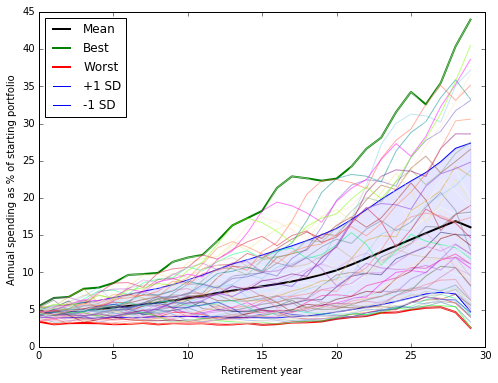

In [80]:
summary = model.cohort_history.summarize_by_year()
summary.to_csv("summary.csv", format="%.18f")
all_years = model.cohort_history.spend_by_year()
all_years.to_csv("years.csv", format="%.18f")
    
df_summary = pd.DataFrame.from_csv("summary.csv")
df_years = pd.DataFrame.from_csv("years.csv")

from pylab import rcParams
rcParams['figure.figsize'] = 8, 6

plt.plot(df_summary.spend_mean, color='k', linewidth=2, label='Mean')
plt.plot(df_summary.spend_max, color='g', linewidth=2, label='Best')
plt.plot(df_summary.spend_min, color='r', linewidth=2, label='Worst')
plt.plot(df_summary.spend_mean + df_summary.spend_sd, color='b', linewidth=1, label='+1 SD')
plt.plot(df_summary.spend_mean - df_summary.spend_sd, color='b', linewidth=1, label='-1 SD')
plt.fill_between(df_summary.index, df_summary.spend_mean + df_summary.spend_sd, 
                 df_summary.spend_mean - df_summary.spend_sd, color='blue', alpha='0.1')

from matplotlib import colors
mycolors =  list(colors.cnames)
random.shuffle(mycolors)

for ix in range(model.first_year, model.first_year + model.ret_cohorts):
    plt.plot(df_years[str(ix)], linewidth=1, color=mycolors[ix-model.first_year], alpha=0.5, label='_nolegend_')

plt.ylabel("Annual spending as % of starting portfolio")
plt.xlabel("Retirement year")
plt.legend(loc="upper left", bbox_to_anchor=[0, 1])
plt.show()

